In [2]:
%load_ext autoreload
%autoreload 2

from collections import deque, Counter

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from cartpole3d import CartPole3D



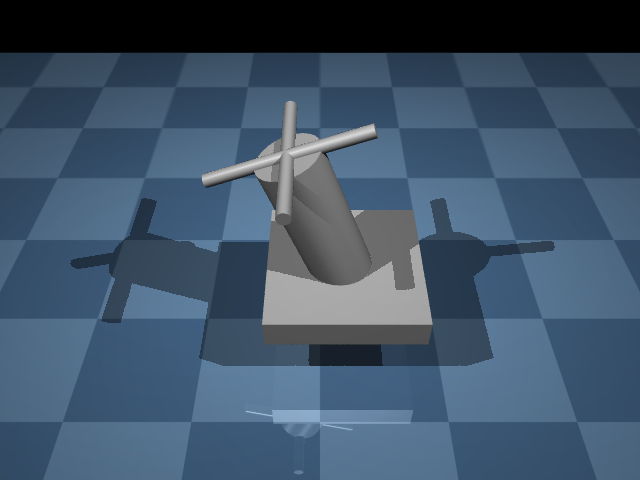

In [3]:
cartpole3d_env = CartPole3D(movement_type='1d')

cartpole3d_env.reset()

for _ in range(100):
    cartpole3d_env.step(100)

cartpole3d_env.render()

In [8]:
torch.set_default_device('cuda:0' if torch.cuda.is_available() else 'cpu')

env = CartPole3D(
    movement_type='1d',
    reset_randomization_magnitude=0.1,
    slide_range=0.3,
    hinge_range=0.8,
    time_limit=10.0,
    step_reward_function= lambda time, state: 1 + time**2,
    out_ouf_range_reward=-0.2,
    time_limit_reward=10000,
)
# env = gym.make("CartPole-v1")
env.reset()

gamma = 0.99


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.affine2 = nn.Linear(128, 1)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.affine2(x)
        return F.tanh(x)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

action_dist_sd = 0.25


def select_action(state, pred_log: list[np.ndarray]):
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    pred = policy(state)
    pred_log.append(pred.detach().numpy())
    
    action_dist = torch.distributions.Normal(pred, action_dist_sd)
    action = action_dist.sample()
    policy.saved_log_probs.append(action_dist.log_prob(action))
    
    return action.detach().numpy()


def finish_episode():
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def translate_action(action):
    # return action
    return action * 1000

def main():
    best_reward = 0
    for i_episode in range(1000):
        state, _ = env.reset()
        ep_reward = 0
        pred_log = []
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = select_action(state, pred_log)
            state, reward, done, _, _ = env.step(translate_action(action))
            
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        finish_episode()
        
        if ep_reward > best_reward:
            best_reward = ep_reward
            torch.save(policy, 'best.pt')
        
        if i_episode % 1 == 0:
            print(f'Episode {i_episode:>4}\t\t'
                  f'Last reward: {ep_reward:>9.2f} \t\t '
                  f'Number of Actions: {t:>5} \t\t '
                  f'Pred mean: {", ".join([f"{m:> 2.4f}" for m in np.mean(pred_log, axis=0)[0]])} \t '
                  f'Pred std: {", ".join([f"{s:> 2.4f}" for s in np.std(pred_log, axis=0)[0]])}')
        if False:
            print("Solved! "
                  "the last episode runs to {} time steps!".format(t))
            break
main()

Episode    0		Last reward:    151.08 		 Number of Actions:   148 		 Pred mean: -0.0007 	 Pred std:  0.0812
Episode    1		Last reward:    869.13 		 Number of Actions:   593 		 Pred mean:  0.0378 	 Pred std:  0.0646
Episode    2		Last reward:    389.51 		 Number of Actions:   339 		 Pred mean:  0.0373 	 Pred std:  0.0675
Episode    3		Last reward:    938.34 		 Number of Actions:   621 		 Pred mean:  0.0469 	 Pred std:  0.0661
Episode    4		Last reward:   5214.39 		 Number of Actions:  1418 		 Pred mean: -0.0184 	 Pred std:  0.0838
Episode    5		Last reward:  27768.75 		 Number of Actions:  2661 		 Pred mean: -0.0023 	 Pred std:  0.0773
Episode    6		Last reward:   2813.13 		 Number of Actions:  1090 		 Pred mean: -0.0010 	 Pred std:  0.1076
Episode    7		Last reward:   2644.57 		 Number of Actions:  1060 		 Pred mean: -0.0036 	 Pred std:  0.0988
Episode    8		Last reward:   2021.92 		 Number of Actions:   935 		 Pred mean:  0.0121 	 Pred std:  0.1091
Episode    9		Last reward:    603.03 

KeyboardInterrupt: 

In [11]:
duration = 5   # (Seconds)
framerate = 30  # (Hz)
video = []
 
last_switch = 0

policy = torch.load('best.pt')

physics = env.physics


state, _ = env.reset()

trace = []

while physics.data.time < duration:
    action = select_action(state, [])
    trace.append((state, action))
    state, reward, done, _, _ = env.step(translate_action(action))

    if len(video) < physics.data.time * framerate:
        
        pixels = physics.render(width=640, height=480, camera_id=-1)
        video.append(pixels.copy())
    
 

trace_states = [t[0] for t in trace]
trace_actions = [t[1] for t in trace]
print(np.mean(trace_actions, axis=0), np.std(trace_actions, axis=0))
display_video(video, framerate)

[[0.09562758]] [[0.40921378]]


C:\Users\Brn\AppData\Local\Temp\ipykernel_16304\2271421933.py:7: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


In [48]:
bucket_size = 25
for i in range(0, len(trace), bucket_size):
    print(f'{i:>5}: \t\t {str(trace_states[i]):<80} {dict(Counter(trace_actions[i:i+bucket_size]))}')

    0: 		 [0.00301361 0.00367415 0.         0.        ]                                    {0: 14, 1: 11}
   25: 		 [ 0.00292876  0.00401671 -0.10202983  0.28135216]                                {1: 11, 0: 14}
   50: 		 [-0.00295657  0.02047702 -0.20547259  0.57582806]                                {0: 11, 1: 14}
   75: 		 [-0.01196818  0.04687255 -0.11103751  0.36473102]                                {1: 14, 0: 11}
  100: 		 [-0.01569649  0.0619232  -0.02066444  0.1907396 ]                                {0: 12, 1: 13}
  125: 		 [-0.01742692  0.07570222 -0.00118233  0.23108436]                                {1: 16, 0: 9}
  150: 		 [-0.01284353  0.0773893   0.21876811 -0.25992532]                                {1: 16, 0: 9}
  175: 		 [ 0.00128048  0.05831053  0.44054853 -0.76694037]                                {1: 13, 0: 12}
  200: 		 [ 0.02666284  0.01235996  0.46714981 -0.79121752]                                {0: 14, 1: 11}
  225: 		 [ 0.04588013 -0.01583977  0.36605822 -

In [10]:
def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [ ]:
physics.data.qpos

array([ 0.80046674, -1.047949  ])

In [122]:
np.concatenate([physics.data.qpos, physics.data.qvel])

array([-0.02168953, -0.03073212,  0.38963361, -0.20229654,  0.22114658,
        0.18125404, -1.93815623,  2.08265143])